# Análise do Nível de Manutenibilidade
<br>
#### Objetivo:<br>
É importante acompanhar se as issues de correção estão levando mais ou menos tempo, e se o software está com os números de defeitos aumentando ou diminuíndo, ou seja, se a sua modificabilidade está melhorando. Uma boa avaliação desses números é conseguir ter correções mais rápidas e sem efeitos colaterais.
Auxiliar futuras refatorações: Quais devem ser as principais para eliminar problemas;<br>
A partir de uma coleção de métricas coletadas automaticamente e de uma forma objetiva de interpretar seus valores, engenheiros de software podem monitorar características especícas do seu código assim como implementações problemáticas para tomar melhores decisões ao (re)escrevê-las.<br>
<br>
#### Vantagens:<br>
-- Possibilita a rápida identificação de falhas e permite ações de correções na mesma velocidade;<br>
-- O desenvolvimento e a aplicação de novos recursos fica mais fácil e rápido;<br>
-- Há um melhor controle de acesso autorizado para as revisões;<br>
-- Conflitos de mudanças são resolvidos com maior agilidade;<br>
-- Erros e códigos de risco são encontrados mais facilmente;<br>
-- Programadores passam a ter uma visão analítica objetiva, que possibilita e ajuda no reconhecimento de onde os mesmo foram ou não precisos e desatentos;<br>
-- ** Com a exclusão de determinadas classes de defeitos, a equipe se encontra concentrada em outros tipos de eficiência do projeto. **<br>
<br>
Não estou analizando:<br>
-- Complexidade Ciclomática (desvios uma função possui: cada comando if, switch, for, while);<br>
-- Metodos com muitos parâmetros;<br>
-- Outras métricas (Sonar);<br>
<br>
#### Próximos trabalhos:<br>
-- Checkins com uma unit;<br>
-- Cruzar dados do RTC;<br>
<br>


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

arquivos = ['main_changeset.csv', 'HorasPorSalt2017.csv']

### Changeset

Extraido do TFS:<br>
```python
tf hist /noprompt /recursive /format:detailed /version:D"1/1/2015"~D"31/12/2015" $/fPJ/PJ/build/release > 
```


** Utilizado arquivo TFS.ipynb para conversão em CSV.

In [2]:
dfChangesets = pd.read_csv(arquivos[0], encoding='ISO-8859-1', delimiter=';', header=None, 
                 names= ["Salt", "Changeset", "Desenv", "Data", "Descricao", "File", "Filename"])

In [3]:
Correcao = ['anderson.albuquerque', 'darlley.silva', 'murilo.guollo', 'wilian.ivo', 'gessileini.clinio', 'william.colombo', 'roni.beltramin', 'cesar.pamplona', 'taissiane.moroso', 'douglas.zuliani', 'francisco.gomes'] 

In [5]:
def Equipe(d): #desenv
    return d in Correcao
dfChangesets['Correcao'] = dfChangesets.Desenv.apply(Equipe)

# Salts

Dados exportados do SAC via SQL.<br>

> OndeDrive/SAC/Horas.sql
```sql
SELECT DISTINCT 
       ia.NUATENDIMENTO,
       IA.NUITEM,
     ia.NUATENDIMENTO || '/' || IA.NUITEM AS SALT,
       RA.CDORIGEMATEND AS ORIGEM,
       --ra.NUSEQVERSAO,
       ve.NURELEASE,
       /*(SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE = 120) AS PRIORIDADES_SOLICITADAS,
       CASE WHEN IA.DTLIMSOLUCAO < CURRENT DATE THEN 'VENCIDA' ELSE 'DENTRO_PRAZO' END SITUACAO_SLA,*/
       CLI.SGCLIENTE AS CLIENTE,
       IA.DTREGISTRO AS DATA_CADASTRO,
       IA.DTLIMSOLUCAO AS DATA_SLA,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 'ZERO/CRÍTICA'
         WHEN 5 THEN 'UM/IMPEDITIVA'
         WHEN 1 THEN 'DOIS/ALTA'
         WHEN 2 THEN 'TRES/MÉDIA'
         WHEN 3 THEN 'QUATRO/BAIXA'
         WHEN 4 THEN 'INDEFINIDA'
       END SEVERIDADE,
       CASE IA.CDPRIORIDADE 
         WHEN 6 THEN 8
         WHEN 5 THEN 5
         WHEN 1 THEN 4
         WHEN 2 THEN 3
         WHEN 3 THEN 2
         WHEN 4 THEN 3
       END PONTUACAO_SEVERIDADE,
       SIT.DESITUACAOATEND AS SITUACAO_SALT,
       /*CASE WHEN (SELECT COUNT(1)
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  AND AA.CDTIPOATIVIDADE IN (243,303)) > 0 THEN 'SIM' ELSE 'NÃO' END AS REJEITE,*/
       AA.NUSEQATIVIDADE,
       AA.CDTIPOATIVIDADE,
       TA.DETIPOATIVIDADE,
       AA.DTREALINICIO,
       AA.DTREALFINAL,
       '0' || CAST(AA.QTHORASREAL AS VARCHAR(10)) AS QTHORASREAL,
    (SELECT '0' || CAST(SUM(AA.QTHORASREAL) AS VARCHAR(10))
                 FROM SAC.ESACATIVIDADE AA
                WHERE AA.CDPROJETO = IA.CDPROJETO
                  AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
                  AND AA.NUITEM = IA.NUITEM
                  --AND AA.CDTIPOATIVIDADE IN (243,303)
                  ) AS HORASTOTAIS
  FROM sac.ESACREGISTROATEND ra
 LEFT JOIN sac.ESACVERSAO ve
    ON ra.CDPROJETO = ve.CDPROJETO
   AND ra.CDSISTEMA = ve.CDSISTEMA
   AND ra.NUSEQVERSAO = ve.NUSEQVERSAO
  JOIN sac.ESACITEMATEND ia
    ON ia.cdProjeto = ia.CDPROJETO
   AND ia.NUATENDIMENTO = ra.NUATENDIMENTO
  JOIN SAC.ESACSITUACAOATEND SIT
    ON SIT.CDSITUACAOATEND = IA.CDSITUACAOATEND
  JOIN sac.ESACATIVIDADE a
    ON a.cdProjeto = ia.CDPROJETO
   AND a.NUATENDIMENTO = ia.NUATENDIMENTO
   AND a.NUITEM = ia.NUITEM
   AND a.CDTIPOATIVIDADE in (162)
  JOIN SAC.ESACCLIENTE CLI
    ON CLI.CDCLIENTE = ra.CDCLIENTE    
  JOIN SAC.ESACATIVIDADE AA
    ON AA.CDPROJETO = IA.CDPROJETO
   AND AA.NUATENDIMENTO = IA.NUATENDIMENTO
   AND AA.NUITEM = IA.NUITEM    
 LEFT  JOIN SAC.ESACTIPOATIVIDADE TA
    ON AA.CDTIPOATIVIDADE = TA.CDTIPOATIVIDADE
 WHERE ra.cdProjeto = 3
--   AND ra.CDORIGEMATEND = 10
   AND ra.CDSISTEMA IN (31,93)
--   AND ra.CDCLIENTE <> 3969
--   AND a.DTENCERRAMENTO IS NULL
--   AND ia.DTLIMSOLUCAO IS NOT NULL
--   AND SIT.CDSITUACAOATEND=65
   AND VARCHAR_FORMAT (ia.DTREGISTRO,'YYYY-MM-DD') > '2017-01-01'
--AND ra.NUATENDIMENTO = 263466
ORDER BY ia.NUATENDIMENTO, IA.NUITEM, AA.NUSEQATIVIDADE
```


In [7]:
dfSalts = pd.read_csv(arquivos[1], encoding='ISO-8859-1', delimiter=',')
dfSalts

,NUATENDIMENTO,NUITEM,SALT,ORIGEM,NURELEASE,CLIENTE,DATA_CADASTRO,DATA_SLA,SEVERIDADE,PONTUACAO_SEVERIDADE,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS
0,4,2,4/2,8,03020100,EQUIPE-SAJ,2017-03-02 16:59:16,NaN,UM/IMPEDITIVA,5,Pendente,1,310,Apontamento de Horas,2017-03-02,2017-03-02,0.016,0.016
1,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-05-11 13:39:16,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,0.750,0.750
2,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,2,16,Avaliação do atendimento,2017-01-18 17:46:04,2017-01-18 17:46:04,3.500,4.500
3,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,3,283,Revisão de código,2017-01-18,2017-01-18,1.000,4.500
4,1003,1,1003/1,8,03030101,EQUIPE-SAJ,2017-05-11 16:46:57,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,0.750,0.750
5,1003,1,1003/1,8,03030101,EQUIPE-SAJ,2017-01-20 15:21:58,NaN,UM/IMPEDITIVA,5,Encerrado,2,16,Avaliação do atendimento,2017-02-01,2017-02-01,1.000,1.000
6,12110,1,12110/1,8,02000000,EQUIPE-SAJ,2017-04-03 10:11:10,NaN,INDEFINIDA,3,Encerrado,1,16,Avaliação do atendimento,2017-04-05,2017-04-05,0.016,0.016
7,12117,1,12117/1,8,02000001,EQUIPE-SAJ,2017-04-26 16:06:22,NaN,TRES/MÉDIA,3,Encerrado,1,918,Atendimento ao Cliente/Suporte,2017-04-26 16:08:14,2017-04-26 16:08:14,0.500,0.500
8,12149,1,12149/1,10,01000304,PGE/PB,2017-10-25 15:02:54,2017-10-31 15:01:59,INDEFINIDA,3,Encerrado,1,918,Atendimento ao Cliente/Suporte,2017-10-20 15:03:47,2017-10-20 15:03:47,1.000,1.000
9,54056,1,54056/1,10,03030704,PGE/SP,5006-08-31,NaN,TRES/MÉDIA,3,Encerrado,1,77,Cadastro do atendimento,2006-09-04,2006-09-04,0.116,0.449


In [8]:
Salts_counts = dfChangesets.Salt.value_counts()
#Salts_uniques = dfChangesets.Salt.unique()#.to_frame()

dfChangesets['conta'] = dfChangesets.Salt.apply(lambda y: 1 if y not in Salts_counts else Salts_counts[y])
dfChangesets['apagar'] = dfChangesets.conta.apply(lambda y: True if y>500 else False)

In [9]:
dfChangesets = dfChangesets[dfChangesets.apagar == False]

In [10]:
dfChangesets = dfChangesets[dfChangesets.Correcao == True]

In [11]:
dfChangesets.head(30)

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Correcao,conta,apagar
0,263572/1,554269,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,3,False
1,263572/1,554269,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjParametroCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,3,False
2,263572/1,554269,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjPendenciaPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,3,False
5,261519/1,554254,anderson.albuquerque,29/12/2017,SALT 261519/1 - Alterado sistema para permitir...,uspjConsInfAdicControladaComCadastro.pas,/fPJ/PJ/build/main/pjDev/src/pj/Cliente/uspjCo...,True,1,False
7,258433/2,554248,anderson.albuquerque,29/12/2017,SALT 258433/2 - Corrigido Problema na consulta...,uspjConstante.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,2,False
8,258433/2,554248,anderson.albuquerque,29/12/2017,SALT 258433/2 - Corrigido Problema na consulta...,uspjPublicdiarioServ.pas,/fPJ/PJ/build/main/pjDev/src/pj/Servidor/uspjP...,True,2,False
9,262499/1,554222,anderson.albuquerque,29/12/2017,SALT 262499/1 - Corrigido problema na atividad...,uspjConfigImpressao.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,1,False
10,260508/1,554202,anderson.albuquerque,29/12/2017,SALT 260508/1 - Correção da apresentação do ca...,uspjSelectFluxoDocumento.pas,/fPJ/PJ/build/main/pjDev/src/pj/Servidor/uspjS...,True,1,False
112,257002/1,554011,darlley.silva,28/12/2017,SALT 257002/1 - Propriedade da distribuição nã...,uspjChefiaCons.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,1,False
257,243357/38,553589,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,spjd5Completo.dpk,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/Pa...,True,5,False


In [12]:
dfAtividades = dfSalts.groupby(['CDTIPOATIVIDADE', 'DETIPOATIVIDADE'])['SALT'].count().to_frame().sort_values(by='SALT', ascending=False)
dfAtividades = [83, 162, 51, 188, 90, 336, 8, 45, 119, 15, 344]
#dfAtividades.Codigo.value_counts
#083	Determinacao das Causas Possiveis
#162	Avalicao atendimento - Correcao
#051	Sincronizacao de fontes para versao de correcao
#188	Avaliacao atendimento - Desenvolvimento PJ
#090	Suporte e apoio t้cnico ao cliente interno
#336	Codificar solucao
#008	Codificacao
#045	Codificacao devido a testes reprovados
#119	Avaliacao atendimento - Desenvolvimento
#015	Script
#344	Corrigir codificacao

dfSalts['AtividadeDesenv'] = dfSalts.CDTIPOATIVIDADE.apply(lambda y: True if y in dfAtividades else False)
#dfSalts['HorasDesenv'] = dfSalts.AtividadeDesenv.apply(lambda y: dfSalts.QTHORASREAL if y == True else 0) #Pupilo
#dfSalts['HorasDesenv'] = 0.00
#dfSalts[dfSalts.AtividadeDesenv == True].HorasDesenv = dfSalts.QTHORASREAL #Pupilo
dfSalts.HorasDesenv = dfSalts.QTHORASREAL
#dfSalts['HorasDesenv'] = dfSalts['AtividadeDesenv', 'QTHORASREAL'].apply(lambda Ativ, Horas: 0 if Ativ == False else Horas)
dfSalts[dfSalts.AtividadeDesenv == True]

,NUATENDIMENTO,NUITEM,SALT,ORIGEM,NURELEASE,CLIENTE,DATA_CADASTRO,DATA_SLA,SEVERIDADE,PONTUACAO_SEVERIDADE,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS,AtividadeDesenv
14,54529,1,54529/1,10,03030900,PGE/ES,2017-01-19 14:37:44,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-01-19 16:51:31,2017-02-14 16:15:59,33.250,33.250,True
15,54531,1,54531/1,10,03030900,PGE/ES,2017-01-19 16:30:26,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-01-19 16:31:46,2017-01-24 09:07:15,6.250,6.250,True
20,54545,1,54545/1,8,03030101,EQUIPE-SAJ,2017-01-31 17:24:54,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-01-31 17:28:48,2017-02-14 16:18:00,2.250,2.250,True
27,54551,1,54551/1,10,03030801,PGE/PE,2017-02-01 14:29:52,NaN,TRES/MÉDIA,3,Encerrado,1,8,Codificação,2017-02-02 08:19:16,2017-02-03 08:19:16,16.000,16.000,True
31,54562,1,54562/1,10,03030801,PGE/PE,2017-02-10 14:53:18,2017-04-03 14:59:58,DOIS/ALTA,4,Encerrado,4,8,Codificação,2017-03-22 09:59:20,2017-03-31 09:49:14,13.916,18.265,True
33,54565,1,54565/1,10,03030900,PGE/ES,2017-02-13 16:41:13,NaN,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-02-07 16:43:25,2017-02-10 16:44:50,28.833,28.833,True
37,54595,1,54595/1,10,03030900,PGE/ES,2017-03-03 08:13:45,2017-03-09 18:00:00,TRES/MÉDIA,3,Encerrado,1,90,Suporte e apoio técnico ao cliente interno,2017-03-02 08:19:14,2017-03-07 11:44:55,0.416,0.416,True
43,54598,1,54598/1,8,03030101,EQUIPE-SAJ,2017-03-03 15:01:27,NaN,TRES/MÉDIA,3,Encerrado,4,8,Codificação,2017-03-08 14:10:36,2017-03-08 14:14:26,4.083,5.432,True
52,54623,1,54623/1,10,03030704,PGE/SP,2017-03-16 09:57:24,2017-03-20 18:00:00,DOIS/ALTA,4,Encerrado,1,8,Codificação,2017-03-16 09:59:20,2017-03-16 09:59:20,2.000,2.000,True
58,54632,1,54632/1,10,03030900,PGE/ES,2017-03-24 11:08:32,NaN,TRES/MÉDIA,3,Encerrado,1,8,Codificação,2017-03-24 08:24:11,2017-03-31 07:53:18,16.500,17.583,True


In [13]:
dfSalts['PerdeuPrazoSla'] = dfSalts.NUATENDIMENTO % 2 == 0
dfSalts.head(5)

,NUATENDIMENTO,NUITEM,SALT,ORIGEM,NURELEASE,CLIENTE,DATA_CADASTRO,DATA_SLA,SEVERIDADE,PONTUACAO_SEVERIDADE,SITUACAO_SALT,NUSEQATIVIDADE,CDTIPOATIVIDADE,DETIPOATIVIDADE,DTREALINICIO,DTREALFINAL,QTHORASREAL,HORASTOTAIS,AtividadeDesenv,PerdeuPrazoSla
0,4,2,4/2,8,03020100,EQUIPE-SAJ,2017-03-02 16:59:16,NaN,UM/IMPEDITIVA,5,Pendente,1,310,Apontamento de Horas,2017-03-02,2017-03-02,0.016,0.016,False,True
1,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-05-11 13:39:16,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,0.750,0.750,False,True
2,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,2,16,Avaliação do atendimento,2017-01-18 17:46:04,2017-01-18 17:46:04,3.500,4.500,False,True
3,1000,1,1000/1,8,03030101,EQUIPE-SAJ,2017-01-18 12:03:04,NaN,DOIS/ALTA,4,Encerrado,3,283,Revisão de código,2017-01-18,2017-01-18,1.000,4.500,False,True
4,1003,1,1003/1,8,03030101,EQUIPE-SAJ,2017-05-11 16:46:57,NaN,INDEFINIDA,3,Encerrado,2,16,Avaliação do atendimento,2017-05-11,2017-05-11,0.750,0.750,False,False


In [14]:
dfSalts['Salt'] = dfSalts.SALT
dfSaltsMerge = dfSalts[dfSalts.AtividadeDesenv == True]
dfSaltsMerge = dfSaltsMerge[['Salt','HORASTOTAIS', 'PerdeuPrazoSla']]
dfSaltsMerge = dfSaltsMerge.drop_duplicates()
dfSaltsMerge

,Salt,HORASTOTAIS,PerdeuPrazoSla
14,54529/1,33.250,False
15,54531/1,6.250,False
20,54545/1,2.250,False
27,54551/1,16.000,False
31,54562/1,18.265,True
33,54565/1,28.833,False
37,54595/1,0.416,False
43,54598/1,5.432,True
52,54623/1,2.000,False
58,54632/1,17.583,True


In [23]:
dfSalts['Salt'] = dfSalts.SALT
dfChangesets = dfChangesets[dfChangesets.Data.notnull()][(dfChangesets.Data.dropna().str.contains('2017'))]
dfChangesets = dfChangesets.merge(dfSaltsMerge, how='right', on='Salt')

In [24]:
dfChangesets.query('conta > 1')

,Salt,Changeset,Desenv,Data,Descricao,File,Filename,Correcao,conta,apagar,HORASTOTAIS_x,PerdeuPrazoSla_x,Media,HORASTOTAIS_y,PerdeuPrazoSla_y
0,263572/1,554269.0,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,3.0,False,20.416,True,6.805333,20.416,True
1,263572/1,554269.0,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjParametroCalculoPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,3.0,False,20.416,True,6.805333,20.416,True
2,263572/1,554269.0,anderson.albuquerque,29/12/2017,SALT 263572/1 - Correção para que o Sistema ig...,uspjPendenciaPrazo.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,3.0,False,20.416,True,6.805333,20.416,True
4,258433/2,554248.0,anderson.albuquerque,29/12/2017,SALT 258433/2 - Corrigido Problema na consulta...,uspjConstante.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,2.0,False,18.430,False,9.215000,18.430,False
5,258433/2,554248.0,anderson.albuquerque,29/12/2017,SALT 258433/2 - Corrigido Problema na consulta...,uspjPublicdiarioServ.pas,/fPJ/PJ/build/main/pjDev/src/pj/Servidor/uspjP...,True,2.0,False,18.430,False,9.215000,18.430,False
9,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,spjd5Completo.dpk,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/Pa...,True,5.0,False,21.564,False,4.312800,21.564,False
10,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,uspjMensagemWSPetIniciaisFactory.pas,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,5.0,False,21.564,False,4.312800,21.564,False
11,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,uspjTratamentoRetornoWSAltSitProcProbAjuiz.pas...,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,5.0,False,21.564,False,4.312800,21.564,False
12,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,uspjTratamentoRetornoWSLancarMovProbAjuiz.pas;...,/fPJ/PJ/build/main/pjDev/src/pj/Componentes/sp...,True,5.0,False,21.564,False,4.312800,21.564,False
13,243357/38,553589.0,darlley.silva,26/12/2017,SALT 243357/38 - Rotinas de ajuizamento não ma...,uspjWsServicoTJServ.pas,/fPJ/PJ/build/main/pjDev/src/pj/Servidor/uspjW...,True,5.0,False,21.564,False,4.312800,21.564,False


In [27]:
dfChangesets['Media'] = dfChangesets.HORASTOTAIS / dfChangesets.conta

AttributeError: 'DataFrame' object has no attribute 'HORASTOTAIS'

In [28]:
HorasFile = dfChangesets[dfChangesets.Correcao == True].groupby('File', as_index=False).agg({"Media": "sum"})
HorasFile = HorasFile.sort_values(by='Media', ascending=False)
HorasFile#.head(100)

,File,Media
226,uspjEdicaoDocumento.pas,258.060200
91,uspjCadProcessoEF.pas,250.503167
321,uspjProcessoServ.pas,245.553456
279,uspjIntimacaoeletServ.pas,236.761509
324,uspjProcessomvServ.pas,183.952804
96,uspjCadProcessoMovBase.pas,183.925550
119,uspjCitacaoEletServ.pas,165.294868
306,uspjPendenciaPrazoServ.pas,163.107600
331,uspjPublicdiarioServ.pas,132.025500
388,uspjVisualizaProcesso.pas,124.041864


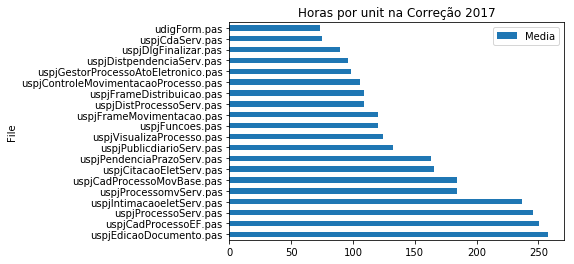

In [31]:
HorasFile[:20].set_index('File').plot(kind='barh')
plt.title("Horas por unit na Correção 2017")
plt.show()

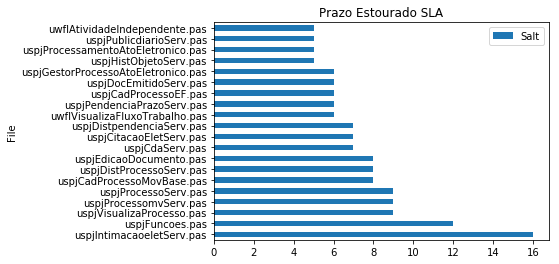

In [32]:
Prazo = dfChangesets[dfChangesets.PerdeuPrazoSla == True].groupby('File', as_index=False).agg({"Salt": "count"})
Prazo = Prazo.sort_values(by='Salt', ascending=False)
Prazo.head(10)

Prazo[:20].set_index('File').plot(kind='barh')
plt.title("Prazo Estourado SLA")
plt.show() #Pupilo

In [ ]:
#Salts por por severidade por unit

PONTUACAO_SEVERIDADE